In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import pickle
from hashlib import md5
import time
import os

def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    path = "../Stan files/pkl_cache"
    if(os.path.isdir(path)==False):
        os.makedirs(path)
    
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = '{}/cached-model-{}.pkl'.format(path,code_hash)
    else:
        cache_fn = '{}/cached-{}-{}.pkl'.format(path,model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code,**kwargs)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

# Posterior 

In [3]:
GP_model = StanModel_cache(model_code=open("../../Stan files/posterior.stan").read())

Using cached StanModel


In [4]:
linear_model = StanModel_cache(model_code=open("../../Stan files/posterior uni.stan").read())

Using cached StanModel


In [5]:
suppGP_model = StanModel_cache(model_code=open("../../Stan files/posterior with support GP.stan").read())


Using cached StanModel


In [6]:
suppGPlin_model = StanModel_cache(model_code=open("../../Stan files/posterior with support GP with linear mean.stan").read())


Using cached StanModel


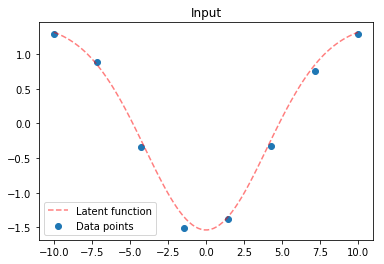

In [7]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def func(x):
    return 1-gaussian(x,0,4) #+ gaussian(x,-5,0.4)*0.05

leng = 10
lendata = 8
#lenpred = 20

xlong = np.linspace(-10,10,100)
xdata = np.linspace(-10,10,lendata)
ydata = func(xdata) + np.random.normal(0,0.005,size=len(xdata))
x = np.linspace(-10,10,leng)
y = func(x) 
ylong = func(xlong)
#xpred = np.linspace(4,10,lenpred)
ycombined = preprocessing.scale(np.append(np.append(ydata,y),ylong))
ydata = ycombined[:len(xdata)]
y = ycombined[len(xdata):-len(xlong)]
ylong = ycombined[-len(xlong):]

#  plt.figure(figsize=(10,10))


plt.scatter(xdata,ydata,label="Data points")
plt.plot(xlong,ylong,'r--',alpha=0.5,label="Latent function")
plt.title('Input')

plt.legend()
# plt.savefig("./%s Input data points.png"%(time.ctime()))

plt.show()

In [8]:
sig =0.1
v= 0.1

posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_prm = len(x),
    x_prm = x,
    sig_var = sig
)

uni_posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_g = len(x),
    x_g = x,
    m_m = np.ones_like(x,dtype=int),
    N_prm = len(x),
    x_prm = x,
    v = v,
    sig_var = sig
)

In [9]:
GP_fit = GP_model.sampling(data=posterior_data,iter=500,chains=2)


/u/26/pais2/unix/.conda/envs/stan_env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [10]:
linear_fit = linear_model.sampling(data=uni_posterior_data,iter=500,chains=2)


/u/26/pais2/unix/.conda/envs/stan_env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [11]:
suppGP_fit = suppGP_model.sampling(data=uni_posterior_data,iter=500,chains=2)


/u/26/pais2/unix/.conda/envs/stan_env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [12]:
suppGPlin_fit = suppGPlin_model.sampling(data=uni_posterior_data,iter=500,chains=2)


/u/26/pais2/unix/.conda/envs/stan_env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [13]:
linear_derv = np.mean(linear_fit.extract(permuted=True)['f'],axis=0)
suppGP_derv = np.mean(suppGP_fit.extract(permuted=True)['f'],axis=0)
suppGPlin_derv = np.mean(suppGPlin_fit.extract(permuted=True)['f'],axis=0)


In [14]:
linear_m = np.mean(linear_fit.extract(permuted=True)['m'],axis=0)
suppGP_m = np.mean(suppGP_fit.extract(permuted=True)['m'],axis=0)
suppGPlin_m = np.mean(suppGPlin_fit.extract(permuted=True)['m'],axis=0)


In [15]:
print(linear_derv.shape)

(28,)


In [16]:
print(suppGP_m.shape)

(20,)


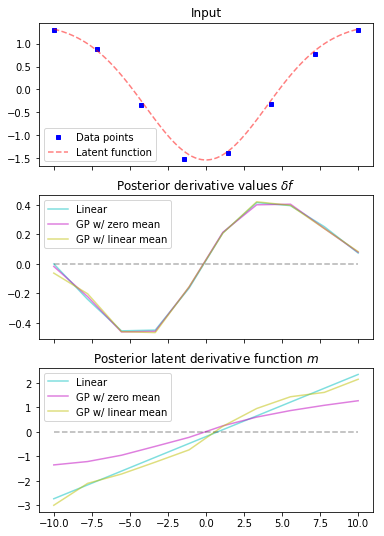

In [31]:
c = ['b', 'c', 'm', 'y']


fig,ax = plt.subplots(3,1,sharex=True)
fig.set_size_inches(6,9)
ax[0].set_title('Input')
ax[0].plot(xdata, ydata, 'bs', ms=4,label="Data points")#  
ax[0].plot(xlong,ylong,'r--',alpha=0.5,label="Latent function")
ax[0].legend()

#plt.subplot(2,2,2)
ax[1].set_title('Posterior derivative values $\delta f$')
ax[1].plot(x, linear_derv[-x.shape[0]:], c[1],alpha=0.5,label="Linear")
ax[1].plot(x, suppGP_derv[-x.shape[0]:], c[2],alpha=0.5,label="GP w/ zero mean")
ax[1].plot(x, suppGPlin_derv[-x.shape[0]:], c[3],alpha=0.5,label="GP w/ linear mean")
ax[1].plot(np.linspace(-10,10,10),np.zeros(10),'k--',alpha=0.3)
ax[1].legend()



ax[2].set_title('Posterior latent derivative function $m$')
ax[2].plot(x, linear_m, c[1],alpha=0.5,label="Linear")
ax[2].plot(x, suppGP_m[:-x.shape[0]], c[2],alpha=0.5,label="GP w/ zero mean")
ax[2].plot(x, suppGPlin_m[:-x.shape[0]], c[3],alpha=0.5,label="GP w/ linear mean")
ax[2].plot(np.linspace(-10,10,10),np.zeros(10),'k--',alpha=0.3)

ax[2].legend()
plt.savefig("./monotonicity.png")
plt.show()